In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding
from torch.utils.data import Dataset, DataLoader
import gym
from torch import optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats

Obsveration:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space:  Discrete(2)


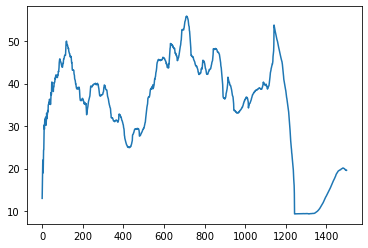

In [2]:
class Actor(nn.Module):
    def __init__(self, dim_state, dim_action, fc1, fc2 ,alpha=1e-4,):
        super(Actor, self).__init__()
        
        self.lr = alpha
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.fc1 = fc1
        self.fc2 = fc2
        
        self.linear1 = nn.Linear(dim_state, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        self.lienar3 = nn.Linear(fc2, dim_action)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)  #Model is automatically assigned to device
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay = 1e-4)
        
    def forward(self, state):
        output = state.to(self.device)
        
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.lienar3(output)
        
        return output

class Agent():
    def __init__(self,env, dim_state, dim_action, fc1, fc2 ,maxm_Iters, alpha=1e-4,gamma=0.99 ):
        self.actor = Actor(dim_state, dim_action, fc1, fc2)
        self.maxm_Iters = maxm_Iters
        self.gamma = gamma
        
    def getValue(self, rewards):
        ##rewards: list of immideate reward
        total_reward = 0
        for i, reward in enumerate(rewards):
            total_reward +=self.gamma**i * reward
        return total_reward
    
    def baseline_Whitening(self,rewards):
        ##rewards: list of immideate reward
        lenth = len(rewards)
        values = np.zeros(lenth)
        for i in range(lenth):
            values[i] = self.getValue(rewards[i:])
        return values.sum()/lenth, np.std(values)
        
    def train(self):
        
        reward_List=[]
        for i in range(self.maxm_Iters):
            rollout = []
            done=False
            state= env.reset()
            rewards = 0
            
            ## Roll out first
            while not done:
                probs = self.actor(torch.tensor(state).float())
                probs = F.softmax(probs, dim=0)
                m = Categorical(probs)
                action = m.sample()
                
                state_new, reward, done, _ = env.step(action.item())
                rewards+=reward
                
                rollout.append((state, action,reward))
                
                state = state_new
                
            ##Use the rollout to update the actor
            ##Obtain the base line first:
            for i, element in enumerate(rollout):
                self.actor.train()
                self.actor.zero_grad()
                
                ##Obtain the baseline b(s) and std 
                baseline, std = self.baseline_Whitening([i[2] for i in rollout])
                baseline = torch.tensor(baseline).float()
                std = torch.tensor(std).float()
                
                value = self.getValue([j[2] for j in rollout[i:]])
                
                probs = self.actor(torch.tensor(element[0]).float())
                probs = F.softmax(probs, dim=0)
                m = Categorical(probs)           
                loss = - m.log_prob(element[1]) * (torch.tensor(value).float() - baseline)
                
                loss.backward()  #Calculate the gradient
                self.actor.optimizer.step()  #Update the weight
            
            reward_List.append(rewards)
        #print(reward_List)
        self.plot_learning_curve(reward_List)
    
    def plot_learning_curve(self,scores):
        x = [i for i in range(len(scores))]
        running_avg = np.zeros(len(x))
        
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x,running_avg)
        plt.show()
    
    
if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    #env = gym.make('MountainCar-v0')
    
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.n
    
    print('Obsveration: ', env.observation_space)
    print('Action space: ', env.action_space)
    
    #(self,env, dim_state, dim_action, fc1, fc2 ,maxm_Iters, alpha=1e-4,gamma=0.99 ):
    agent = Agent(env,dim_state,dim_action, 256, 256, 1500, alpha=1e-2)
    agent.train()
